In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.base import BaseTransformer

from sktime.transformations.compose import FeatureUnion
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures

from catboost import CatBoostRegressor
import shap as sp

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv('daily-website-visitors.csv')[["Date", "Page.Loads", "Unique.Visits", "First.Time.Visits", "Returning.Visits"]]
df = df.rename(columns={"Date": 'ds', 
                        "Page.Loads": 'y1',
                        "Unique.Visits": 'y2',
                        "First.Time.Visits": 'y3',
                        "Returning.Visits": 'y4'
                       })

In [4]:
targets = ['y1', 'y2', 'y3', 'y4']

In [5]:
df['ds'] = pd.to_datetime(df.ds, yearfirst = True)

for target in targets : 
    df[target] = df[target].str.replace(',','.').astype("float")

df = df.set_index('ds')

In [6]:
class ZScoreTransformer(BaseTransformer):
    def __init__(self, window=30):
        self.window = window
        super(ZScoreTransformer, self).__init__()

    def transform(self, Z, X=None):
        z = Z.copy()
        z_score = (z['y'] -  z['y'].rolling(window=self.window).mean()) / z['y'].rolling(window=self.window).std()
        z.loc[np.abs(z_score > 3), 'y'] = np.nan
        return z
    
    def inverse_transform(self, Z, X=None):
        return Z

def inverse_transform(pipeline, X_transformed):
    for name, transformer in reversed(pipeline.steps):
        X_transformed = transformer.inverse_transform(X_transformed)
    return X_transformed

In [7]:
transform = Pipeline(
    steps=[
        ("log", LogTransformer(offset=1)),
        #("differencer", Differencer(lags=1)),
        #("z_score", ZScoreTransformer(window=30)),
        #("imputer", Imputer(method="drift")),
        ("scale", TabularToSeriesAdaptor(StandardScaler())),
    ]
)

window_summarizer = WindowSummarizer(
    lag_feature={
        "lag": list(range(1, 8)) + [14],
        "mean": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
        "std": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
    }
)

fourier_featurizer = FourierFeatures(sp_list=[365.25, 7], fourier_terms_list=[10, 2], freq='D')

featurizer = FeatureUnion([window_summarizer, fourier_featurizer])

In [8]:
lag_features = [f"WindowSummarizer__y_lag_{i}" for i in window_summarizer.lag_feature["lag"]]
mean_features = [f"WindowSummarizer__y_mean_{start}_{end}" for start, end in window_summarizer.lag_feature["mean"]]
std_features = [f"WindowSummarizer__y_std_{start}_{end}" for start, end in window_summarizer.lag_feature["std"]]
fourier_features = [f"FourierFeatures__{fn}_{per}_{i}" for per, freq in zip(fourier_featurizer.sp_list, fourier_featurizer.fourier_terms_list) for i in range(1, freq + 1) for fn in ("cos", "sin")]
to_update_features = lag_features + mean_features + std_features

MSE: 0.2845018224302738
MAPE: 0.1044558798146564


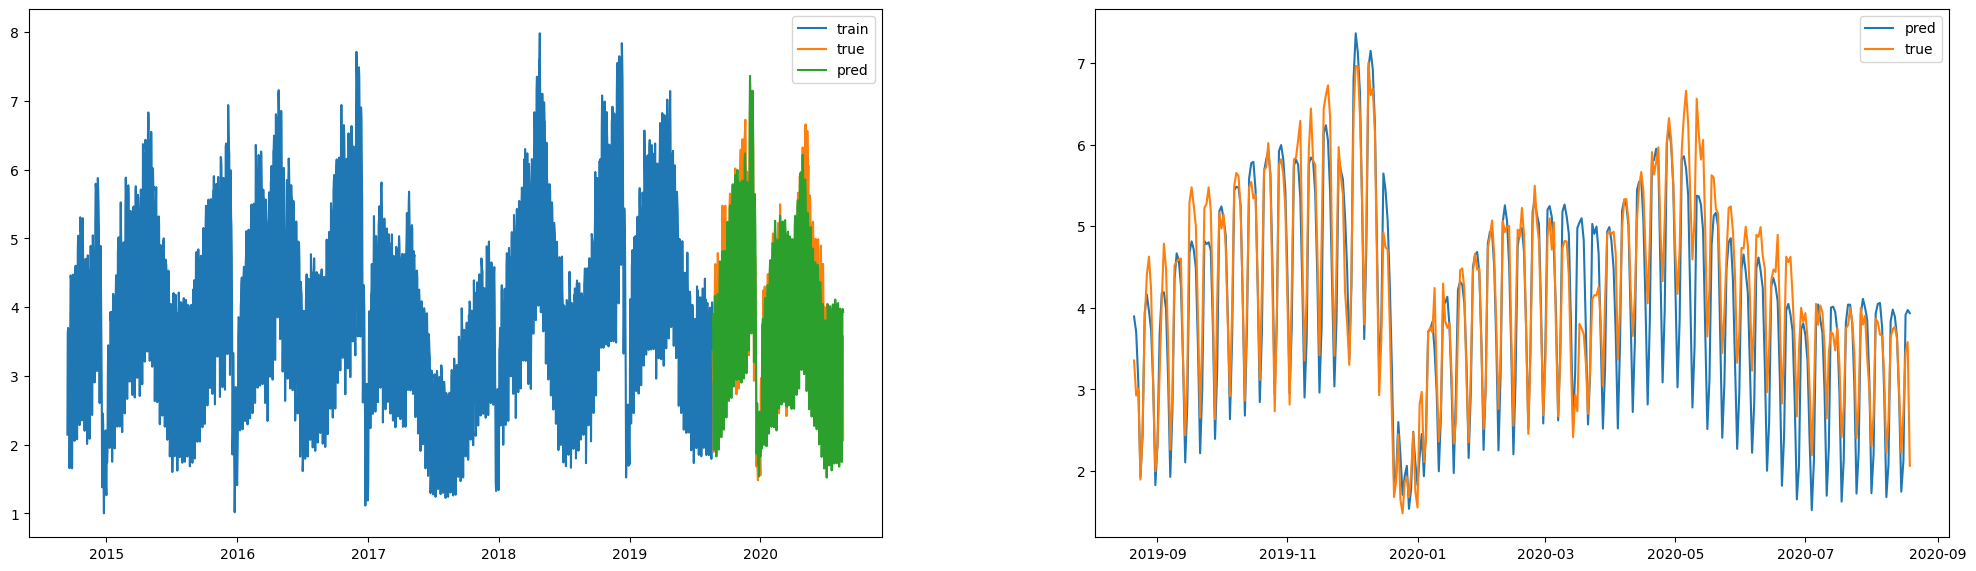

MSE: 11.074537038865108
MAPE: 0.3968528080152429


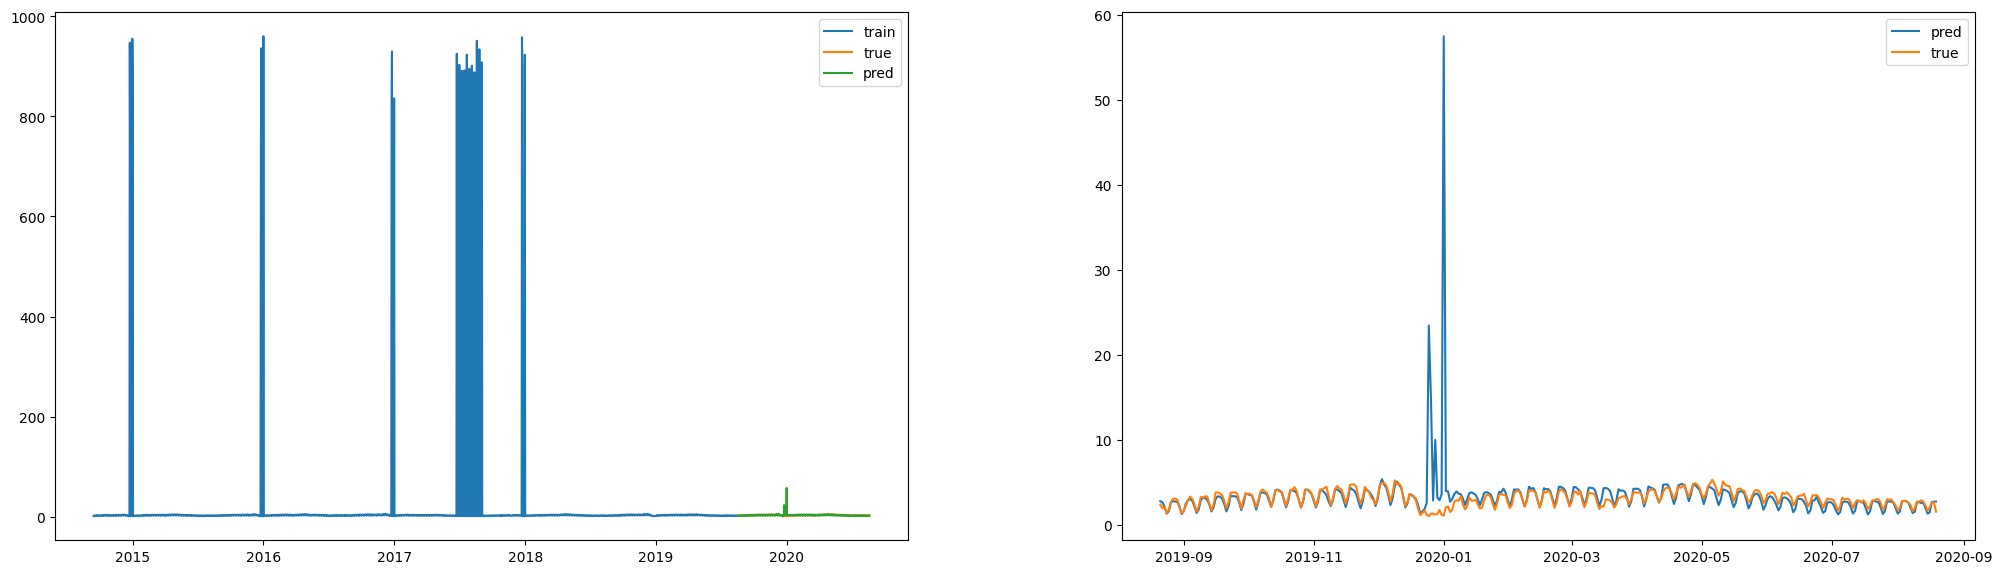

MSE: 6416.760741167189
MAPE: 3.666345180377568


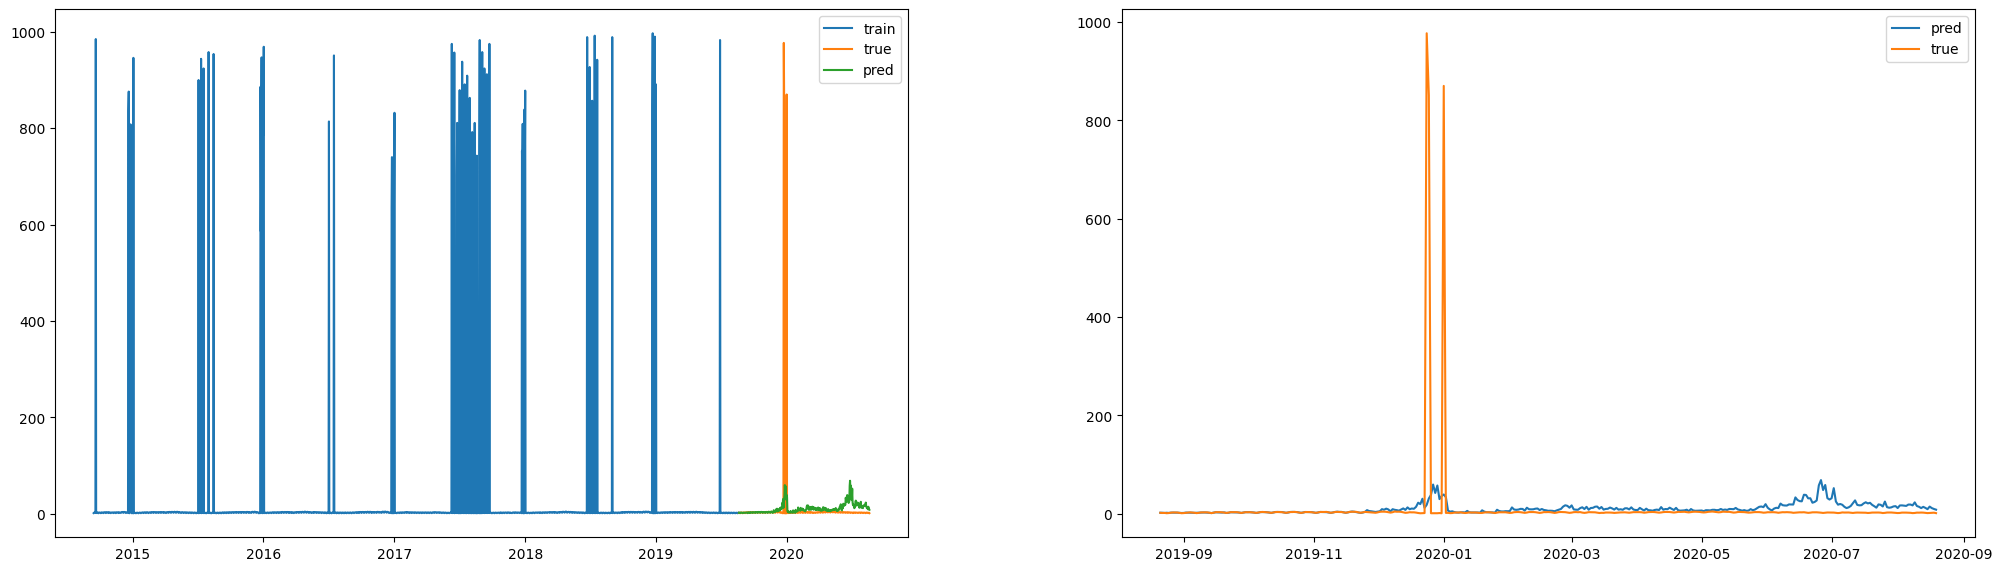

MSE: 4162.520252074862
MAPE: 0.11850207062082763


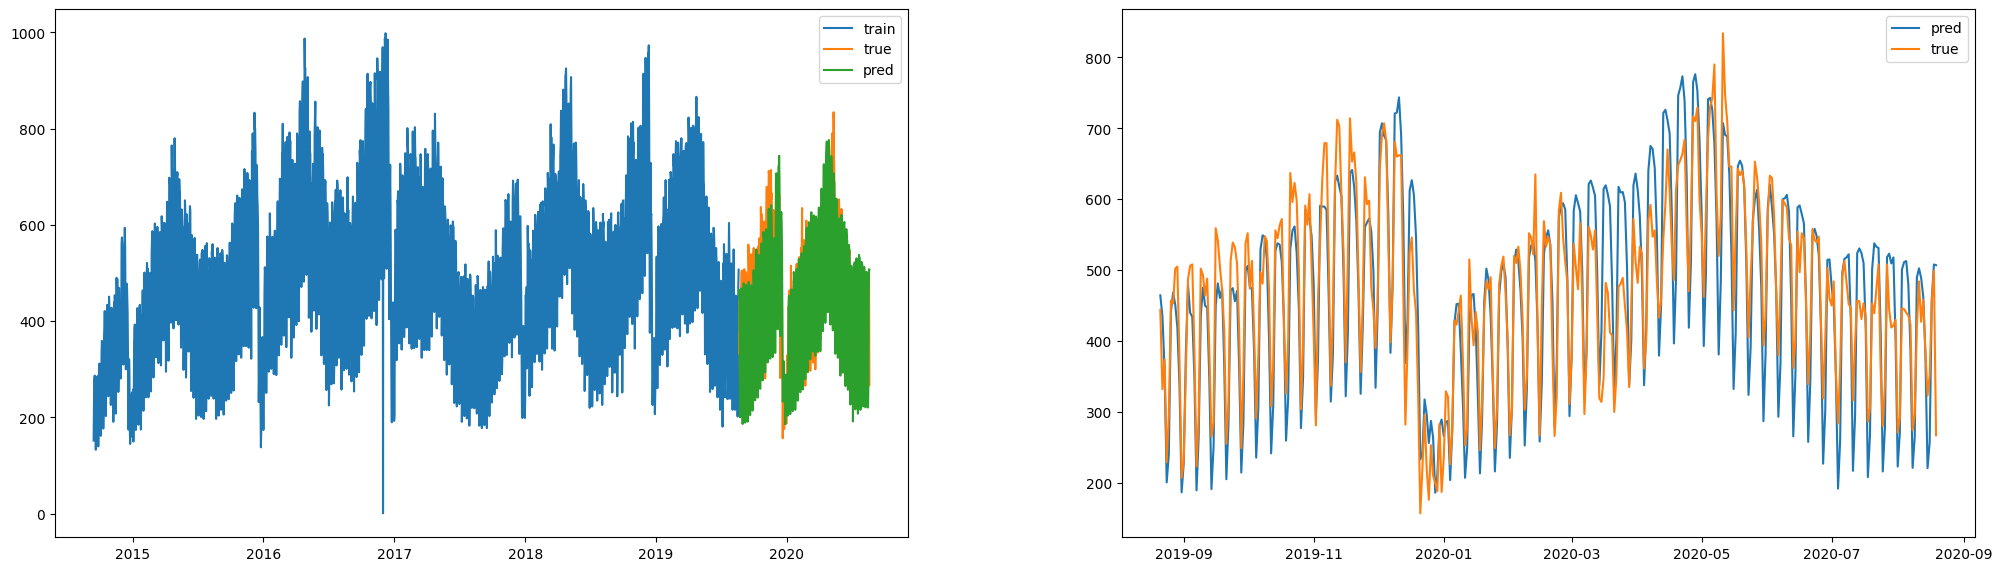

In [9]:
for target in targets:
    y_train, y_test = temporal_train_test_split(df[[target]].rename(columns={target:'y'}), test_size=365)
    index_train, index_test = y_train.index, y_test.index
    
    y_train_transform = transform.fit_transform(y_train)
    y_full_transform = y_train_transform.reindex(y_train_transform.index.union(y_test.index))
    X_full = featurizer.fit_transform(y_full_transform)
    
    X_full = X_full[lag_features + mean_features + std_features + fourier_features]
    X_train, X_test = X_full.loc[index_train], X_full.loc[index_test]
    
    model = CatBoostRegressor(loss_function="RMSE", has_time=True)
    model.fit(X_train, y_train_transform, verbose=False)
    
    for idx in index_test:
        y_tmp = y_full_transform.loc[idx-pd.DateOffset(28+1):idx]
        X_test.loc[idx, to_update_features] = featurizer.transform(y_tmp).loc[idx, to_update_features]
        y_full_transform.loc[idx] = model.predict(X_test.loc[idx])
    
    y_pred = inverse_transform(transform, y_full_transform.loc[index_test])

    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))
    
    fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)

    ax0.plot(y_train.index, y_train.y, label='train')
    ax0.plot(y_test.index, y_test.y, label='true')
    ax0.plot(y_pred.index, y_pred.y, label='pred')
    ax0.legend()

    ax1.plot(y_pred.index, y_pred.y, label='pred')
    ax1.plot(y_test.index, y_test.y, label='true')
    ax1.legend()

    plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
    plt.show()


#     explainer = sp.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_train)

#     sp.summary_plot(shap_values, X_train, max_display=30 )
#     plt.show()